In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, asdict
from typing import Dict, List
import json

# --- Seed Definitions ---
INDUSTRIES = ["tech", "finance", "healthcare", "manufacturing", "government"]
SIZES = ["small", "mid", "large", "enterprise"]
RECOMMENDATION_DOMAINS = ["product_roadmap", "hiring", "budget", "compliance", "pricing", "market_entry", "vendor_selection"]
VISIBILITY = ["private", "public"]

def sample_org_seed(seed: int | None = None) -> dict:
    rng = np.random.default_rng(seed)
    return {
        "industry_id": int(rng.integers(0, len(INDUSTRIES))),
        "size_id": int(rng.integers(0, len(SIZES))),
        "power_distance": float(rng.random()),
        "sanction_salience": float(rng.random()),
        "in_group_bias": float(rng.random())
    }

def sample_rec_seed(seed: int | None = None) -> dict:
    rng = np.random.default_rng(seed)
    return {
        "domain_id": int(rng.integers(0, len(RECOMMENDATION_DOMAINS))),
        "theta_ideal": float(rng.random()),
        "urgency": float(rng.random()),
        "resource_need": float(rng.random())
    }

def sample_situation_seed(seed: int | None = None) -> dict:
    rng = np.random.default_rng(seed)
    return {
        "theta_current": float(rng.random()),
        "visibility_flag": int(rng.integers(0, 2)),
        "sanction_strength": float(rng.random()),
        "provocation_flag": int(rng.integers(0, 2))
    }



In [7]:
class OrganizationHiddenState:
    """
    A self-contained class to generate and hold the complete state of a simulated organization.
    """
    def __init__(self,
                 org_seed: dict,
                 rec_seed: dict,
                 situation_seed: dict,
                 # High-level graph parameters
                 num_employees: int = 100,
                 levels_dist: Dict[str, int] = None,
                 departments: List[str] = None,
                 avg_span_of_control: int = 5):

        # --- Store Seeds ---
        self.org_seed = org_seed
        self.rec_seed = rec_seed
        self.situation_seed = situation_seed
        
        # --- Store Graph Generation Parameters ---
        self.N = num_employees
        self.levels = levels_dist or {'C-Suite': 1, 'Director': 4, 'Manager': 15, 'IC': 80}
        self.departments = departments or ['Engineering', 'Marketing', 'Sales', 'HR']
        self.avg_span_of_control = avg_span_of_control

        # --- Internal State (to be generated) ---
        self.employees = None
        self.graphs = {}

        # --- Execute Generation ---
        self._generate_full_state()

    def _generate_full_state(self):
        """Orchestrates the generation of the entire organizational state."""
        self._generate_roster()
        self._generate_reports_to_graph()
        self._generate_collaboration_graph()
        self._generate_friendship_graph()
        self._generate_influence_graph()
        self._generate_conflict_graph()
        
    def _generate_roster(self):
        """Generates the employee dataframe."""
        employee_levels = [level for level, count in self.levels.items() for _ in range(count)]
        
        department_assignments = []
        for level in employee_levels:
            p = [0.5, 0.2, 0.2, 0.1] if level in ['IC', 'Manager'] else None
            department_assignments.append(np.random.choice(self.departments, p=p))
        
        self.employees = pd.DataFrame({
            'employee_id': range(self.N),
            'level': employee_levels,
            'department': department_assignments,
            'tenure': np.random.randint(1, 11, size=self.N)
        })
        self.employees['manager_id'] = -1

    def _generate_reports_to_graph(self):
        """Generates the 'reports_to' graph."""
        A_reports = np.zeros((self.N, self.N), dtype=int)
        level_keys = list(self.levels.keys())
        
        for i in range(len(level_keys) - 1):
            manager_level, report_level = level_keys[i], level_keys[i+1]
            manager_indices = self.employees[self.employees['level'] == manager_level].index.to_numpy()
            report_indices = self.employees[self.employees['level'] == report_level].index

            manager_slots = np.repeat(manager_indices, self.avg_span_of_control)
            np.random.shuffle(manager_slots)
            manager_slots = manager_slots.tolist()

            for report_idx in report_indices:
                if manager_slots:
                    manager_idx = manager_slots.pop()
                    A_reports[manager_idx, report_idx] = 1
                    self.employees.loc[report_idx, 'manager_id'] = manager_idx
        
        self.graphs['reports_to'] = A_reports
        
    def _generate_collaboration_graph(self):
        """Generates the 'collaboration' graph."""
        A_collab = np.zeros((self.N, self.N), dtype=float)
        A_reports = self.graphs['reports_to']
        
        for i in range(self.N):
            for j in range(i, self.N):
                if i == j: continue
                prob = np.random.rand() * 0.1
                manager_i = self.employees.loc[i, 'manager_id']
                manager_j = self.employees.loc[j, 'manager_id']
                
                if A_reports[i, j] == 1 or A_reports[j, i] == 1:
                    prob = 0.7 + np.random.rand() * 0.2
                elif manager_i != -1 and manager_i == manager_j:
                    prob = 0.6 + np.random.rand() * 0.2
                elif self.employees.loc[i, 'department'] == self.employees.loc[j, 'department']:
                    prob = 0.2 + np.random.rand() * 0.2
                
                A_collab[i, j] = A_collab[j, i] = prob
        
        self.graphs['collaboration'] = A_collab

    def _generate_friendship_graph(self):
        """Generates the 'friendship' graph."""
        A_friend = np.zeros((self.N, self.N), dtype=int)
        A_collab = self.graphs['collaboration']
        friendship_threshold = 0.7
        
        for i in range(self.N):
            for j in range(i, self.N):
                if i == j: continue
                score = A_collab[i, j]
                if self.employees.loc[i, 'level'] == self.employees.loc[j, 'level']: score += 0.2
                if self.employees.loc[i, 'department'] == self.employees.loc[j, 'department']: score += 0.1
                tenure_diff = abs(self.employees.loc[i, 'tenure'] - self.employees.loc[j, 'tenure'])
                score += max(0, 0.1 - tenure_diff * 0.02)
                
                if score > friendship_threshold:
                    A_friend[i, j] = A_friend[j, i] = 1
                    
        self.graphs['friendship'] = A_friend

    def _generate_influence_graph(self):
        """Generates the 'influence' graph."""
        A_influence = np.zeros((self.N, self.N), dtype=float)
        A_reports = self.graphs['reports_to']
        
        social_graph_matrix = self.graphs['collaboration'] + self.graphs['friendship']
        G_social = nx.from_numpy_array(social_graph_matrix)
        pagerank = nx.pagerank(G_social, weight='weight')
        informal_influence = pd.Series(pagerank)
        
        level_influence_map = {'C-Suite': 0.4, 'Director': 0.3, 'Manager': 0.2, 'IC': 0.1}
        
        for i in range(self.N):
            for j in range(self.N):
                if i == j: continue
                score = 0
                if A_reports[i, j] == 1: score += 0.5
                score += level_influence_map.get(self.employees.loc[i, 'level'], 0)
                score += informal_influence[i] * 0.5
                A_influence[i, j] = np.clip(score, 0, 1)

        self.graphs['influence'] = A_influence

    def _generate_conflict_graph(self):
        """Generates the 'conflict/tension' graph."""
        A_conflict = np.zeros((self.N, self.N), dtype=float)
        competing_depts = {'Sales': ['Engineering', 'Marketing'], 'Engineering': ['Sales', 'Marketing']}
        
        for i in range(self.N):
            for j in range(i, self.N):
                if i == j: continue
                prob = np.random.rand() * 0.1
                if self.employees.loc[i, 'level'] == self.employees.loc[j, 'level']: prob += 0.1
                
                dept_i = self.employees.loc[i, 'department']
                dept_j = self.employees.loc[j, 'department']
                if dept_j in competing_depts.get(dept_i, []): prob += 0.2
                
                if self.graphs['friendship'][i, j] == 1: prob *= 0.1
                prob *= (1 - self.graphs['collaboration'][i, j])
                
                A_conflict[i, j] = A_conflict[j, i] = np.clip(prob, 0, 1)

        self.graphs['conflict'] = A_conflict
        
    def to_json_encoding(self, indent=4) -> str:
        """Encodes the entire hidden state into a structured JSON string."""
        encoding = {
            "org_seed": {**self.org_seed, "industry": INDUSTRIES[self.org_seed['industry_id']], "size": SIZES[self.org_seed['size_id']]},
            "rec_seed": {**self.rec_seed, "domain": RECOMMENDATION_DOMAINS[self.rec_seed['domain_id']]},
            "situation_seed": {**self.situation_seed, "visibility": VISIBILITY[self.situation_seed['visibility_flag']]},
            "employees": self.employees.to_dict('records'),
            "graphs": {name: matrix.tolist() for name, matrix in self.graphs.items()}
        }
        # Remove raw IDs from seed encodings
        del encoding['org_seed']['industry_id'], encoding['org_seed']['size_id']
        del encoding['rec_seed']['domain_id']
        del encoding['situation_seed']['visibility_flag']

        return json.dumps(encoding, indent=indent)

    def visualize_graph(self, graph_name: str):
        """Helper to quickly visualize one of the generated graphs."""
        if graph_name not in self.graphs:
            print(f"Graph '{graph_name}' not found. Available graphs: {list(self.graphs.keys())}")
            return
        
        matrix = self.graphs[graph_name]
        plt.figure(figsize=(8, 8))
        sns.heatmap(matrix)
        plt.title(f"'{graph_name.title()}' Adjacency Matrix")
        plt.show()




--- Visualizing Collaboration Graph ---


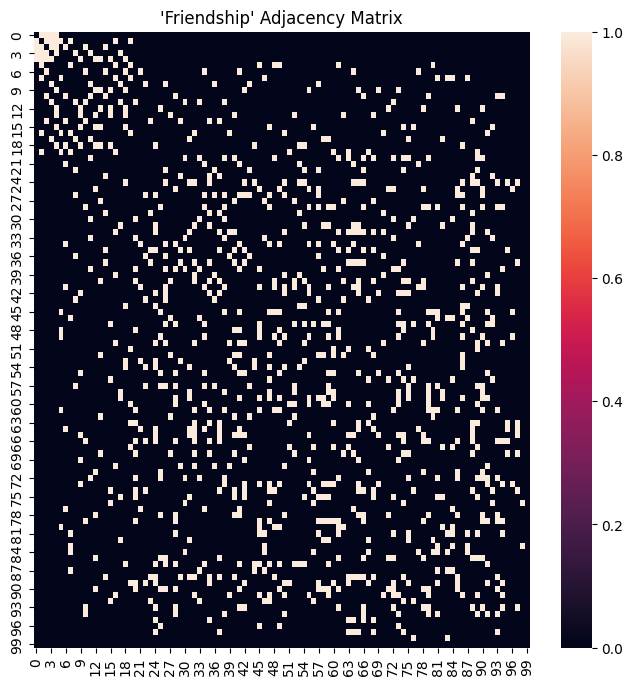

In [11]:
# --- Demonstration ---

# 1. Sample the seeds
org1_seed = sample_org_seed(seed=123)
rec1_seed = sample_rec_seed(seed=456)
sit1_seed = sample_situation_seed(seed=789)

# 2. Instantiate the class to generate the full state
#    This single call now orchestrates the entire generation process.
hidden_state = OrganizationHiddenState(
    org_seed=org1_seed,
    rec_seed=rec1_seed,
    situation_seed=sit1_seed
)

# 3. Verify the JSON encoding
json_output = hidden_state.to_json_encoding()
#print("--- Sample of JSON Encoding ---")
#print(json_output[:1000] + "\n...")
file_path = "sample_hidden_states/sample_0.json"
with open(file_path, "w") as f:
    f.write(json_output)

# 4. Visualize a graph to confirm generation
print("\n--- Visualizing Collaboration Graph ---")
hidden_state.visualize_graph('friendship')



